<a href="https://colab.research.google.com/github/Caceres-A01706972/FruitsVegetables/blob/main/Final_Model_FruitsVegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificador Fruits and Vegetables**

### ***Objetivo:***

Desarrollar un clasificador de frutas y vegetales utilizando técnicas de aprendizaje automático.

Lo principal es clasificar imágenes estáticas de frutas y vegetales. Pero en futuras versiones se planea extender esta capacidad para clasificar en tiempo real utilizando la cámara, permitiendo llevar un registro de la cantidad de cada producto mostrado.

Esta funcionalidad está diseñada para facilitar el conteo y seguimiento de productos en un entorno de supermercado.

### ***Drive con el Dataset:***
[Dataset de Fruitas y Vegetales](https://drive.google.com/drive/folders/1Jkadebp3GhvkF-c1rBmxgevV6G_3diNX?usp=sharing)

### ***Nombre y Matricula:***

Ricardo Andrés Cáceres Villibord A01706972

## Conectando Google Drive y Configurango el directorio

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Aqui dse debe de sustituir el path en donde fue guardada la carpeta del Dataset
%cd "/content/drive/MyDrive/IA_8vo/Proyecto IA"
!ls

Mounted at /content/drive
/content/drive/MyDrive/IA_8vo/Proyecto IA
'Copy of FruitsVegetables.ipynb'	     fruit_vegetable_classifier_Second.h5
 Dataset				     fruit_vegetable_classifier_Second.keras
 FruitsVegetables.ipynb			     fruit_vegetable_classifier_Simple.h5
 fruit_vegetable_classifier_MobileNetV2.h5  'Segundo Modelo.ipynb'


## Importando librerias necesarias

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from PIL import Image

## Directorios de Train, Test y Validation

In [3]:
base_dir = 'Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

## Para sacar las rutas de las imagenes y sus categorias

In [4]:
def proc_img(directorio):
  image_paths = []
  categories = []

  # Recorrer todas las carpetas (categorías) y añadir las imagenes a la lista
  for category in os.listdir(directorio):
      category_path = os.path.join(directorio, category)
      if os.path.isdir(category_path):
          for img_name in os.listdir(category_path):
              if img_name.endswith(('.png', '.jpg', '.jpeg')):
                  image_paths.append(os.path.join(category_path, img_name))
                  categories.append(category)

  # Ponerlo en un Dataframe para facil visualizacion
  df = pd.DataFrame({
      'image_path': image_paths,
      'category': categories
  })

  return df

train_df = proc_img(train_dir)
test_df = proc_img(test_dir)
validation_df = proc_img(validation_dir)

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.category.unique())}\n')
print(f'Labels: {train_df.category.unique()}')

-- Training set --

Number of pictures: 3040

Number of different labels: 36

Labels: ['banana' 'apple' 'bell pepper' 'beetroot' 'ginger' 'chilli pepper'
 'cauliflower' 'cucumber' 'corn' 'cabbage' 'capsicum' 'carrot' 'garlic'
 'eggplant' 'onion' 'lettuce' 'pear' 'orange' 'lemon' 'mango' 'grapes'
 'kiwi' 'jalepeno' 'paprika' 'peas' 'pineapple' 'raddish' 'soy beans'
 'sweetpotato' 'potato' 'tomato' 'sweetcorn' 'spinach' 'pomegranate'
 'turnip' 'watermelon']


In [6]:
train_df.head(5)

,image_path,category
0,Dataset/train/banana/Image_1.jpg,banana
1,Dataset/train/banana/Image_31.jpg,banana
2,Dataset/train/banana/Image_43.png,banana
3,Dataset/train/banana/Image_40.jpg,banana
4,Dataset/train/banana/Image_25.jpg,banana


## Visualización random de como son las imagenes

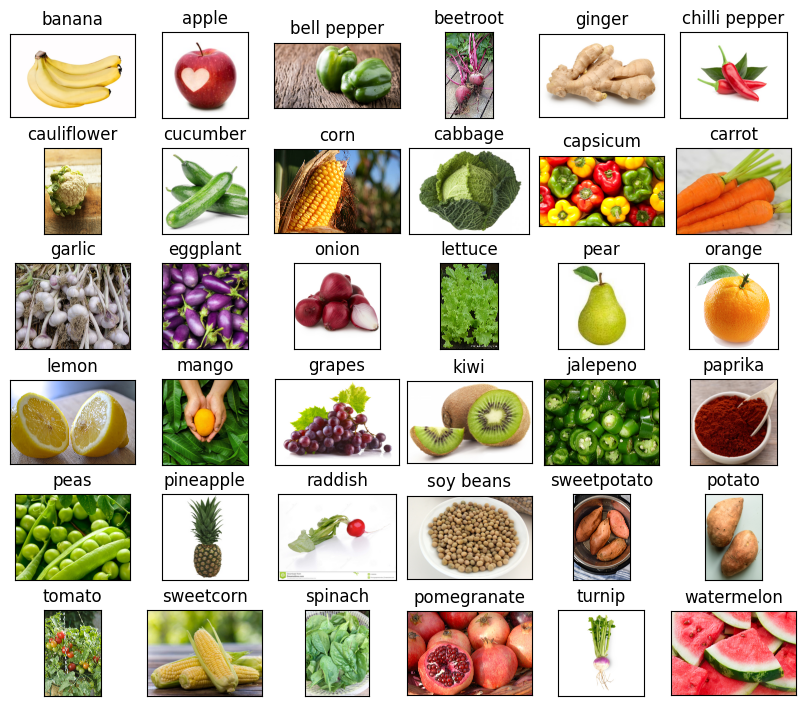

In [7]:
df_unique = train_df.copy().drop_duplicates(subset=["category"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.image_path[i]))
    ax.set_title(df_unique.category[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## Data Augmentation
Esto geenera nuevas imagenes en el ram mientras se entrena. (En cada epoca se va a usar una version modificada de la imagen)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3040 validated image filenames belonging to 36 classes.
Found 345 validated image filenames belonging to 36 classes.
Found 353 validated image filenames belonging to 36 classes.


In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
95/95 [==============================] - 989s 10s/step - loss: 1.6736 - accuracy: 0.5543 - val_loss: 0.3880 - val_accuracy: 0.9014
Epoch 2/5
95/95 [==============================] - 242s 3s/step - loss: 0.5269 - accuracy: 0.8286 - val_loss: 0.3405 - val_accuracy: 0.8957
Epoch 3/5
95/95 [==============================] - 237s 2s/step - loss: 0.3185 - accuracy: 0.8928 - val_loss: 0.1938 - val_accuracy: 0.9478
Epoch 4/5
95/95 [==============================] - 245s 3s/step - loss: 0.1981 - accuracy: 0.9359 - val_loss: 0.1755 - val_accuracy: 0.9507
Epoch 5/5
95/95 [==============================] - 242s 3s/step - loss: 0.1412 - accuracy: 0.9563 - val_loss: 0.1477 - val_accuracy: 0.9623


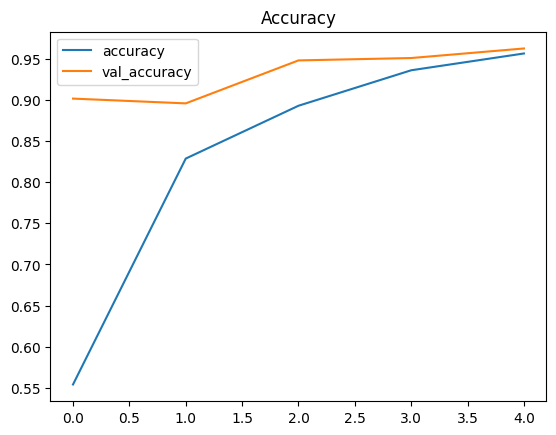

In [11]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

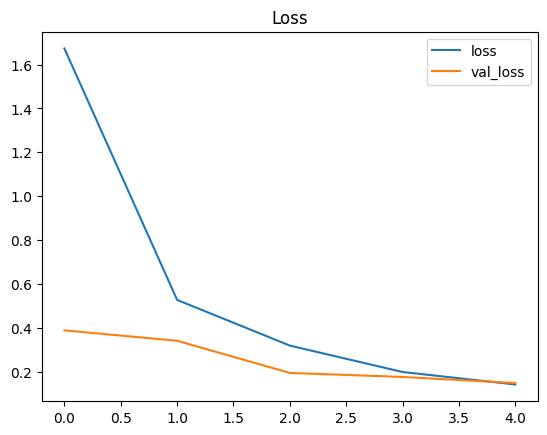

In [12]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [13]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

12/12 [==============================] - 93s 8s/step


In [14]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 96.32%


In [17]:
cr = classification_report(y_test, pred)
print('Classification Report:\n', cr)

Classification Report:
                precision    recall  f1-score   support

        apple       0.88      0.78      0.82         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      0.90      0.86        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.78      0.88         9
       carrot       1.00      0.89      0.94         9
  cauliflower       1.00      1.00      1.00         9
chilli pepper       0.91      1.00      0.95        10
         corn       1.00      0.70      0.82        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00      1.00      

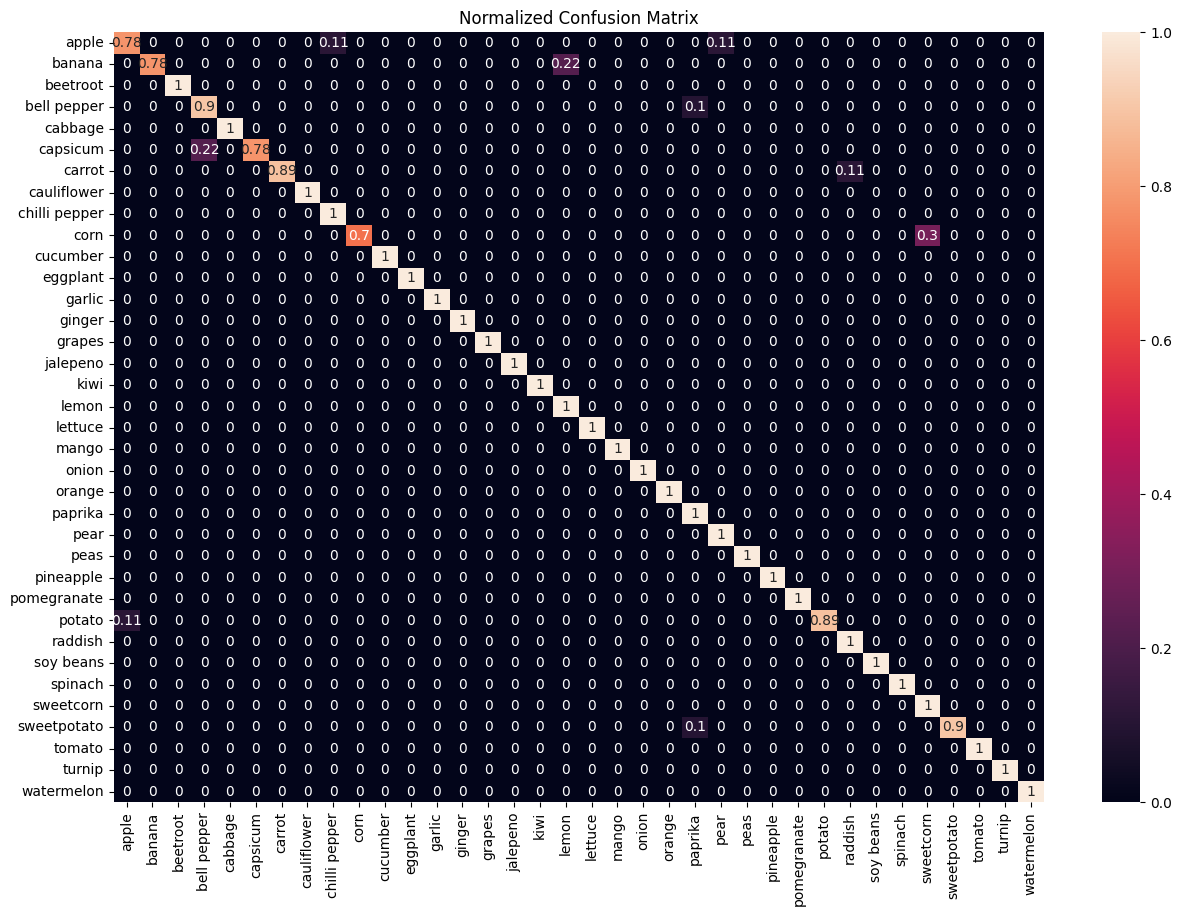

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix,
            annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

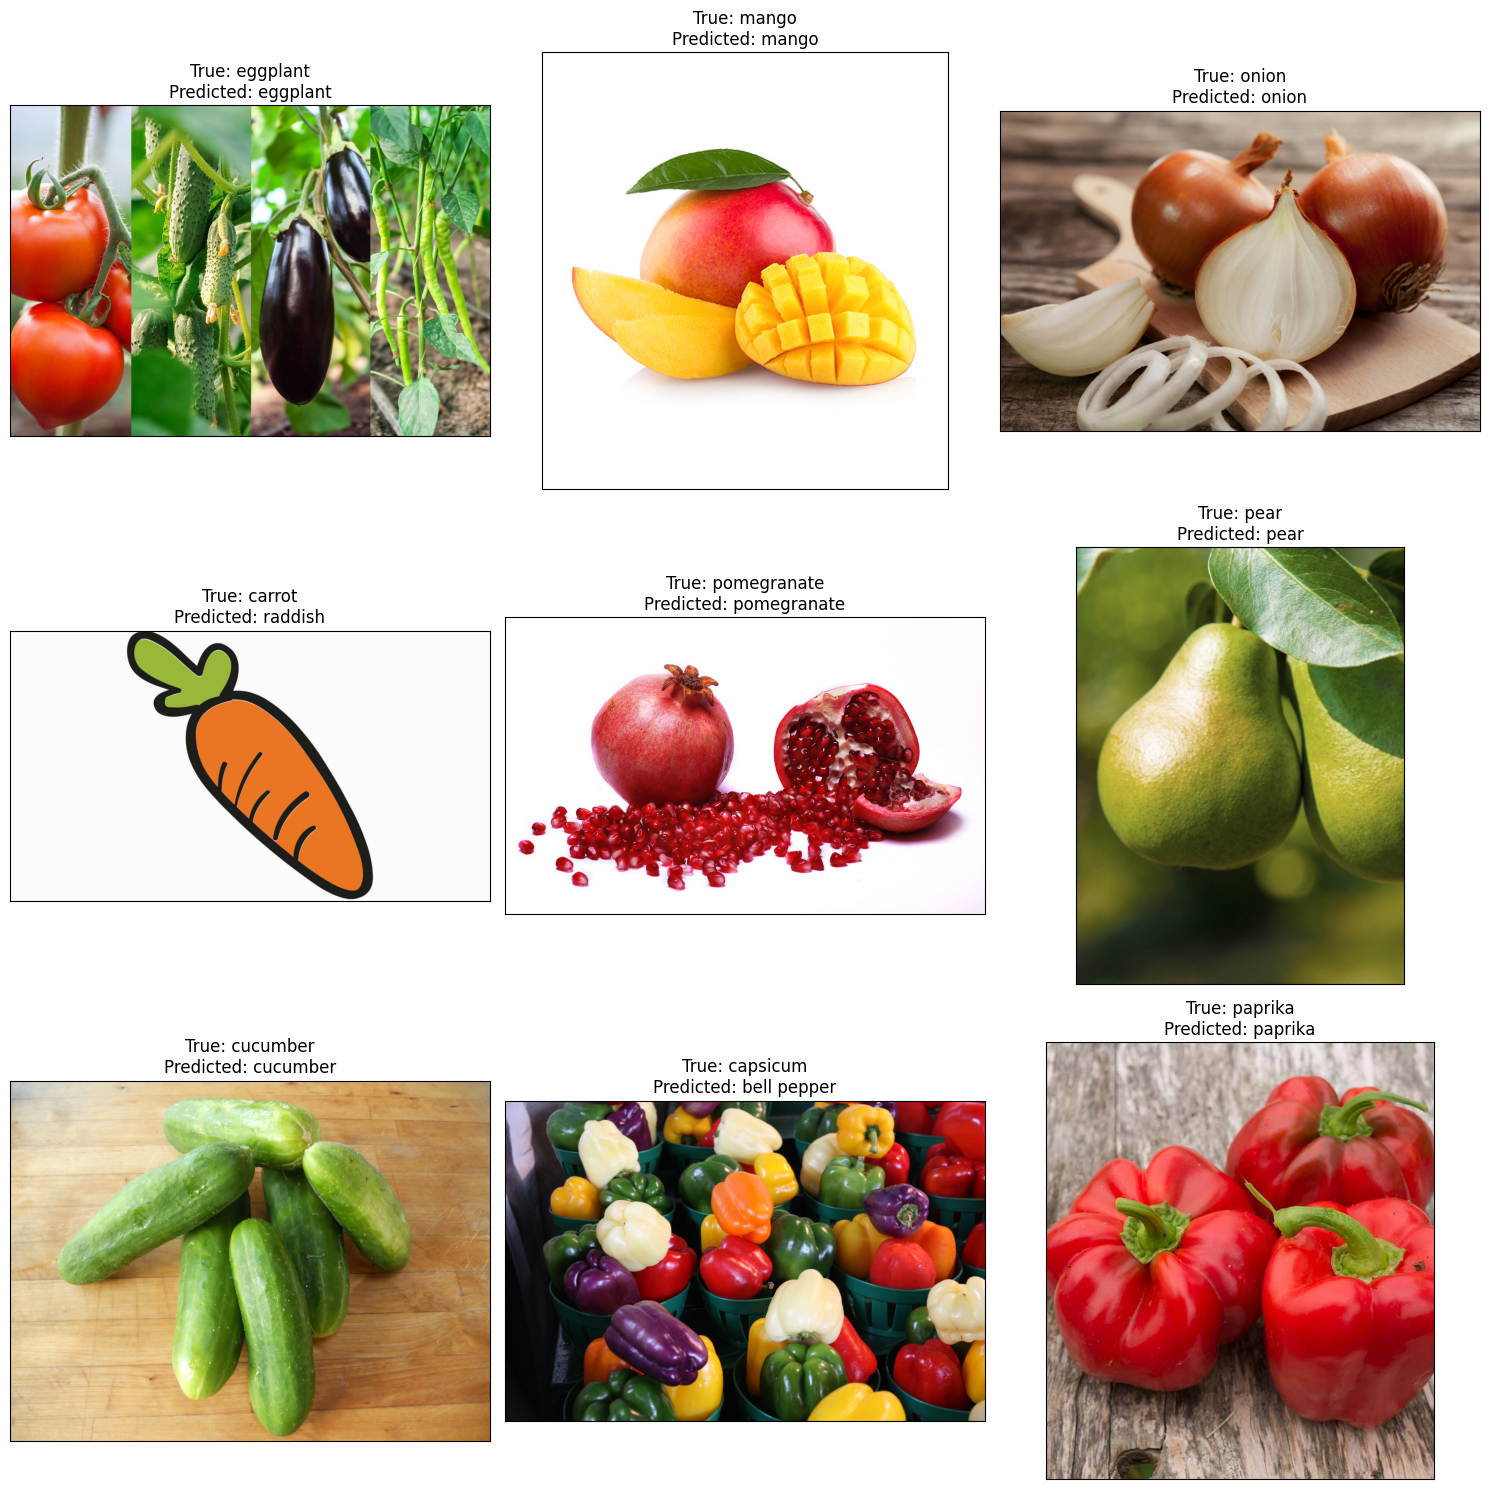

In [22]:
# Número de imágenes a mostrar
num_images = 9

# Generar índices aleatorios
random_indices = np.random.choice(range(len(test_df)), size=num_images, replace=False)

# Crear la figura y los ejes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

# Mostrar las imágenes aleatorias con sus etiquetas verdaderas y predicciones
for ax, idx in zip(axes.flat, random_indices):
    ax.imshow(plt.imread(test_df.image_path.iloc[idx]))
    ax.set_title(f"True: {test_df.category.iloc[idx]}\nPredicted: {pred[idx]}")
plt.tight_layout()
plt.show()

In [23]:
# Guardar el modelo completo en el sistema de archivos temporal
model.save('fruit_vegetable_classifier_MobileNetV2.h5')

# Guardar el modelo en Google Drive
model_save_path = '/content/drive/MyDrive/IA_8vo/Proyecto IA/fruit_vegetable_classifier_MobileNetV2.h5'
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Cargar el modelo guardado desde Google Drive
from tensorflow.keras.models import load_model
cnn = load_model('/content/drive/MyDrive/IA_8vo/Proyecto IA/fruit_vegetable_classifier_MobileNetV2.h5')

In [25]:
categories = train_df['category'].unique()
print(categories)

['banana' 'apple' 'bell pepper' 'beetroot' 'ginger' 'chilli pepper'
 'cauliflower' 'cucumber' 'corn' 'cabbage' 'capsicum' 'carrot' 'garlic'
 'eggplant' 'onion' 'lettuce' 'pear' 'orange' 'lemon' 'mango' 'grapes'
 'kiwi' 'jalepeno' 'paprika' 'peas' 'pineapple' 'raddish' 'soy beans'
 'sweetpotato' 'potato' 'tomato' 'sweetcorn' 'spinach' 'pomegranate'
 'turnip' 'watermelon']


Saving pina.jpg to pina.jpg
1/1 [==============================] - 1s 955ms/step


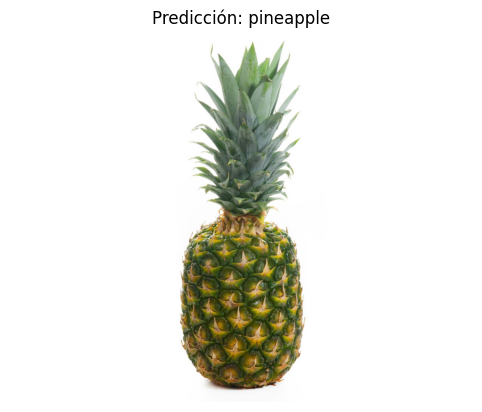

La imagen cargada es de la clase: pineapple


In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
from PIL import Image


# Función para cargar y preprocesar la imagen
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Cambia a 64x64 si es necesario
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalizar la imagen
    return img_array

# Pedir al usuario que cargue una imagen
uploaded = files.upload()

for img_path in uploaded.keys():
    # Preprocesar la imagen cargada
    img_array = load_and_preprocess_image(img_path)

    # Hacer la predicción
    prediction = cnn.predict(img_array)

    # Obtener la etiqueta de clase
    class_names = categories
    predicted_class = np.argmax(prediction, axis=1)
    predicted_class_name = class_names[predicted_class[0]]

    # Mostrar la imagen y la predicción
    plt.imshow(Image.open(img_path))
    plt.title(f'Predicción: {predicted_class_name}')
    plt.axis('off')
    plt.show()

    print(f'La imagen cargada es de la clase: {predicted_class_name}')